<a href="https://colab.research.google.com/github/JuvignyEnsta/Cours_Ensta_2026/blob/main/travaux_diriges/tp5/TP_numero_cinq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurer votre colab pour le calcul sur GPU
Dans le menu au dessus, choisir le sous-menu **Exécution** puis l'option **Modifier le type d'exécution**.

Une fenêtre apparaît où vous pouvez choisir un accélérateur matériel. Choisissez un *GPU* puis *enregistrer* votre choix.

Afin de vérifier que vous avez bien configuré votre session pour utiliser un GPU, exécuter le code ci-dessous (en passant la souris, une petite flèche pour l'exécuter apparaît).

Si tout se passe bien, un tableau (en ascii) apparaît avec le type de carte (et son architecture) auquel vous avez accès. Si un message d'erreur apparaît, vérifiez dans **Modifier le type d'exécution** que l'accélérateur matériel est bien configuré pour un *GPU*

In [ ]:
!nvidia-smi

Tue Feb 17 10:26:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installation de PyCuda

Pour utiliser le GPU sous Python il faut soit installer **PyCuda** pour effectuer des calculs, soit **PyTorch** pour effectuer du machine learning accéléré par les GPUs.

Dans ce TP, nous nous bornerons uniquement à effectuer des calculs sur GPU !

Pour cela, il faut d'abord installer pyCuda et donc exécuter le code ci-dessous (toujours en appuyant sur la flèche pour exécuter le code, et attendez, cela prend un petit moment...)

In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2026.1-cp312-cp312-linux_x86_64.whl size=659448 sha256=5e2989dc9b20db785a8f0476a10d8c0327a20455f63669e428129f9ace0b59d7
  Stored in directory: /root/.cache/pip/wheels/90/2a/71/75ec0cc316cc0ff494bfffa2935e02580129cb7f859a0cfd8f
Successfully built pycuda


# Vérification du bon fonctionnement du module PyCuda

Afin de vérifier le bon fonctionnement de l'installation, nous allons écrire un script Cuda qui servira en même temps d'exemple pour le TP d'aujourd'hui. Ce script sera scindé en plusieurs morceaux et commenté pour que vous compreniez chaque partie du code.

Ce code sera très simple : on va créer une matrice 4x4 avec des données prises "au hasard" (mais avec une graine aléatoire fixée, donc...) , recopier ce tableau dans la mémoire de la carte graphique et demander à la carte graphique de doubler la valeur de chaque élément de la matrice puis de recopier dans la mémoire de l'ordinateur les valeurs calculées. On affiche ensuite la matrice initiale et la matrice transformée.

Dans un premier temps, chargeons les modules python nécessaire à l'exécution d'un noyau Cuda (**Remarque** : l'importation de ces modules n'est nécessaire qu'une seule fois pour **TOUTE** la session. Il sera donc inutile de reimporter ces modules dans le reste du TD !) :

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Créons à l'aide de numpy un tableau *a* dont les valeurs aléatoires sont issues d'une graine fixée :

In [ ]:
import numpy
numpy.random.seed(1729)
a = numpy.random.randn(4,4) # Sous forme de matrice 4 x 4

Puisque certaines cartes graphiques supportent mal le double précision, nous allons demander à Python que les éléments de *a* soient en simple précision :

In [ ]:
a = a.astype(numpy.float32)
print(a.nbytes)

64


Nous allons ensuite allouer de la place mémoire sur la mémoire vive du GPU. Comme en C, la place mémoire est exprimée en *Octets* :

In [ ]:
a_gpu = cuda.mem_alloc(a.nbytes)

Une fois la réservation sur le GPU de faite, on recopie les valeurs de *a* dans le tableau *a_gpu* que l'on vient de réserver (htod signifie host **to** device):

In [ ]:
cuda.memcpy_htod(a_gpu, a)

Il faut ensuite écrire le noyau qui s'exécutera sur la carte graphique à l'aide du langage CUDA (qui est une extension du langage C).

**Remarquez** dans le code qu'on s'assure que les indices donnés par les numéros de threads ne dépassent pas la dimension de la matrice !

In [ ]:
mod = SourceModule("""
__global__ void doublify( int dim_x, int dim_y, float *a )
{
  int tx = threadIdx.x + blockIdx.x * blockDim.x;
  int ty = threadIdx.y + blockIdx.y * blockDim.y;
  int idx = tx + ty * dim_x;

  if ((tx < dim_x) && (ty < dim_y))
  {
    a[idx] *= 2;
  }
}
""")

Nous allons récupérer ensuite un "handle" sur le noyau cuda que l'on vient de créer (en invoquant le nom de la fonction) et l'invoquer sur la carte graphique en dimensionnant la grille de calcul à l'aide de *block=(4,4,1)* (et en l'adaptant aux dimensions de la matrice).

Ici, nous n'avons pas besoin de configurer de grilles car la dimension de la matrice *a* est petite, mais comme la taille d'un bloc dans une direction est limitée à 256, pour des cas plus gros, il faudra également passer une grille en paramètre à l'aide de *grid=(x,y,z)* où *x,y* et *z* sont des valeurs entières positives et utiliser dans le noyau cuda les valeurs *x,y* et *z* de **blockIdx** et **blockDim**.

**REMARQUE IMPORTANTE** : Le noyau cuda ne veut que des types C basiques en argument. Or un entier python est tout sauf un type basique du C. Donc pour passer un argument entier à un noyau cuda, il faut créer un entier 32 bits à l'aide de numpy.int32

In [ ]:
func = mod.get_function("doublify")
dim = numpy.int32(4)
func(dim, dim, a_gpu, block=(4,4,1), grid = (1,1))


Il ne reste plus qu'à récupérer les nouvelles valeurs de la matrice en transférant les données de la matrice contenue par le GPU dans un tableau numpy se trouvant dans la RAM de l'ordinateur (dtoh signifie device **to** host) :

In [ ]:
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

Il ne reste plus qu'à afficher la matrice initiale puis la matrice obtenue par le calcul sur GPU :

In [ ]:
print(f"a : {a}")
print(f"a_gpu : {a_doubled}")

a : [[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]
a_gpu : [[-10.997431   -13.135916    26.437775    -9.204689  ]
 [ 17.583485    14.815137   -15.894621   -13.731538  ]
 [  1.1981882    8.469688     1.9352248   -3.5907779 ]
 [-24.906857     0.89505404   2.5835445  -34.154266  ]]


## Exercices de mises en bouche

En vous inspirant du programme commenté ci-dessus, écrivez un code avec un noyau Cuda qui fait la somme de deux vecteurs de réels simples précisions et qui range le résultat dans un troisième vecteur.

On s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux dans le noyau cuda à l'aide de *threadIdx.x*, *blockIdx.x* et *dimBlock.x*.

Ecrivez (ou copier coller) votre code dans la cellule ci-dessous

In [ ]:

# Define the CUDA kernel for vector addition
mod = SourceModule("""
__global__ void add_vectors(int n, float *a, float *b, float *c)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < n)
    {
        c[idx] = a[idx] + b[idx];
    }
}
""")

# Get the kernel function
add_vectors_func = mod.get_function("add_vectors")

# Define vector size (s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux )
vec_size = 1000  # Example size, greater than 256

# Create two input vectors of single precision floats
a = numpy.random.randn(vec_size).astype(numpy.float32)
b = numpy.random.randn(vec_size).astype(numpy.float32)

# Allocate memory on the GPU for input and output vectors
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(a.nbytes) # Result vector will have same size as inputs

# Copy input vectors from host to device
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

# Determine grid and block dimensions
block_size = 256
grid_size = (vec_size + block_size - 1) // block_size

# Convert vec_size to numpy.int32 for CUDA kernel
n_elements = numpy.int32(vec_size)

# Execute the kernel
add_vectors_func(n_elements, a_gpu, b_gpu, c_gpu, block=(block_size, 1, 1), grid=(grid_size, 1))

# Create an empty numpy array to store the result from the GPU
c_host = numpy.empty_like(a)

# Copy the result from device to host
cuda.memcpy_dtoh(c_host, c_gpu)

# Print a few elements to verify
print("Vector A (first 5 elements):", a[:5])
print("Vector B (first 5 elements):", b[:5])
print("Vector C (first 5 elements, GPU result):", c_host[:5])
print("Vector A + B (first 5 elements, CPU calculation):", (a + b)[:5])

# Verify correctness
print("Are results close?", numpy.allclose(c_host, a + b))

Vector A (first 5 elements): [0.10967004 0.44301215 0.39626622 0.2497974  1.2984973 ]
Vector B (first 5 elements): [-1.1096088   0.60815895  1.5171828  -0.75298774 -1.8437122 ]
Vector C (first 5 elements, GPU result): [-0.9999387   1.0511711   1.913449   -0.50319034 -0.5452149 ]
Vector A + B (first 5 elements, CPU calculation): [-0.9999387   1.0511711   1.913449   -0.50319034 -0.5452149 ]
Are results close? True


Une fois le code mis au point, recopiez le ci-dessous et adaptez le pour additionner deux matrices carrées dans une troisième.

In [ ]:

# Define the CUDA kernel for matrix addition
mod = SourceModule("""
__global__ void add_matrices(int N, float *a, float *b, float *c)
{
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N)
    {
        int idx = row * N + col;
        c[idx] = a[idx] + b[idx];
    }
}
""")

# Get the kernel function
add_matrices_func = mod.get_function("add_matrices")

# Define matrix size (N x N)
matrix_size_N = 500

# Create two input square matrices of single precision floats
a_matrix = numpy.random.randn(matrix_size_N, matrix_size_N).astype(numpy.float32)
b_matrix = numpy.random.randn(matrix_size_N, matrix_size_N).astype(numpy.float32)

# Allocate memory on the GPU for input and output matrices
a_gpu_matrix = cuda.mem_alloc(a_matrix.nbytes)
b_gpu_matrix = cuda.mem_alloc(b_matrix.nbytes)
c_gpu_matrix = cuda.mem_alloc(a_matrix.nbytes) # Result matrix will have same size

# Copy input matrices from host to device
cuda.memcpy_htod(a_gpu_matrix, a_matrix)
cuda.memcpy_htod(b_gpu_matrix, b_matrix)

# Grid block dimensions
block_dim_x = 16
block_dim_y = 16

grid_dim_x = (matrix_size_N + block_dim_x - 1) // block_dim_x
grid_dim_y = (matrix_size_N + block_dim_y - 1) // block_dim_y

# Convert matrix_size_N to numpy.int32 for CUDA kernel
n_elements = numpy.int32(matrix_size_N)

# Execute the kernel
add_matrices_func(n_elements, a_gpu_matrix, b_gpu_matrix, c_gpu_matrix,
                    block=(block_dim_x, block_dim_y, 1),
                    grid=(grid_dim_x, grid_dim_y))

# Create an empty numpy array to store the result from the GPU
c_host_matrix = numpy.empty_like(a_matrix)

# Copy the result from device to host
cuda.memcpy_dtoh(c_host_matrix, c_gpu_matrix)

# Print a few elements to verify (e.g., top-left corner)
print("Matrix A (top-left 3x3 elements):\n", a_matrix[:3, :3])
print("Matrix B (top-left 3x3 elements):\n", b_matrix[:3, :3])
print("Matrix C (top-left 3x3 elements, GPU result):\n", c_host_matrix[:3, :3])
print("Matrix A + B (top-left 3x3 elements, CPU calculation):\n", (a_matrix + b_matrix)[:3, :3])

# Verify correctness
print("Are results close?", numpy.allclose(c_host_matrix, a_matrix + b_matrix))

Matrix A (top-left 3x3 elements):
 [[ 0.6491703   0.02842279  0.4239559 ]
 [ 0.6268369  -0.740522   -0.72687596]
 [-0.2318819   0.2829524   1.0831769 ]]
Matrix B (top-left 3x3 elements):
 [[-0.84463024  0.07448327 -0.45462617]
 [ 1.2487475  -0.06135952 -0.26492488]
 [ 0.573617   -1.2716855   1.6354728 ]]
Matrix C (top-left 3x3 elements, GPU result):
 [[-0.19545996  0.10290606 -0.03067029]
 [ 1.8755844  -0.80188155 -0.99180084]
 [ 0.34173506 -0.98873305  2.7186496 ]]
Matrix A + B (top-left 3x3 elements, CPU calculation):
 [[-0.19545996  0.10290606 -0.03067029]
 [ 1.8755844  -0.80188155 -0.99180084]
 [ 0.34173506 -0.98873305  2.7186496 ]]
Are results close? True


# Exercice final

Nous allons de nouveau nous intéresser à l'ensemble de Mandelbrot. La cellule ci-dessous contient un code permettant de calculer à l'aide de numpy un ensemble de mandelbrot (le code est simplifié par rapport aux codes sur CPU pour faciliter le TP même si il utilise la notation vectorielle de numpy (il faudra y faire attention pour code le noyau cuda !) : code repris de https://stackoverflow.com/questions/60467316/displaying-mandelbrot-set-in-python-using-matplotlib-pyplot-and-numpy).

Transformez le de sorte que sur GPU, chaque thread calcule un pixel de l'image de destination.

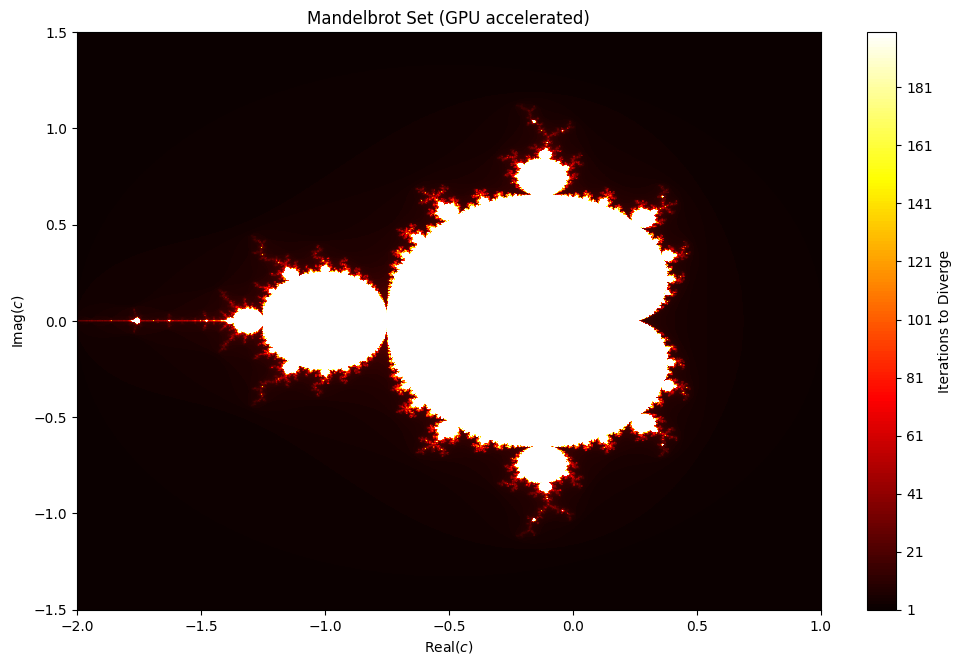

In [ ]:
# Define the CUDA kernel for Mandelbrot calculation
mod = SourceModule("""
#define MAX_ITERATIONS 200 // Max iterations, can be passed as argument too

__global__ void mandelbrot_kernel(
    int width, int height,
    float xmin, float ymin, float xmax, float ymax,
    int max_iterations, int *output
) {
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;

    if (col < width && row < height) {
        // Map pixel coordinates to complex plane coordinates
        float dx = (xmax - xmin) / width;
        float dy = (ymax - ymin) / height;

        float cx = xmin + col * dx;
        float cy = ymin + row * dy;

        float zx = 0.0f;
        float zy = 0.0f;
        int iteration = 0;

        // Mandelbrot iteration: z = z*z + c
        while (zx * zx + zy * zy < 4.0f && iteration < max_iterations) {
            float temp_zx = zx * zx - zy * zy + cx;
            zy = 2.0f * zx * zy + cy;
            zx = temp_zx;
            iteration++;
        }
        // Store iteration count in the output array
        output[row * width + col] = iteration;
    }
}
""")

# Get the kernel function
mandelbrot_func = mod.get_function("mandelbrot_kernel")

# --- Parameters for Mandelbrot Set ---
loop = 200  # Max iterations for a point (changed from 100 to 200 for better detail)
div = 1000  # Image resolution (width and height)

# Complex plane boundaries
xmin_h = -2.0
ymin_h = -1.5
xmax_h = 1.0  # Adjusted xmax from 2.0 to 1.0 to center the set better
ymax_h = 1.5

# Convert parameters to appropriate numpy types for CUDA kernel
width_d = np.int32(div)
height_d = np.int32(div)
xmin_d = np.float32(xmin_h)
ymin_d = np.float32(ymin_h)
xmax_d = np.float32(xmax_h)
ymax_d = np.float32(ymax_h)
max_iterations_d = np.int32(loop)

# Create host array for output (iteration counts for each pixel)
h_colors = np.empty((div, div), dtype=np.int32)

# Allocate device memory for output
d_colors = cuda.mem_alloc(h_colors.nbytes)

# --- Configure CUDA launch parameters ---
block_dim_x = 16
block_dim_y = 16

grid_dim_x = (div + block_dim_x - 1) // block_dim_x
grid_dim_y = (div + block_dim_y - 1) // block_dim_y

# Execute the CUDA kernel
mandelbrot_func(
    width_d, height_d,
    xmin_d, ymin_d, xmax_d, ymax_d,
    max_iterations_d,
    d_colors,
    block=(block_dim_x, block_dim_y, 1),
    grid=(grid_dim_x, grid_dim_y)
)

# Copy the result back from device to host
cuda.memcpy_dtoh(h_colors, d_colors)

# --- Plotting the Mandelbrot Set ---
plt.rcParams['figure.figsize'] = [12, 7.5]

x_coords = np.linspace(xmin_h, xmax_h, div)
y_coords = np.linspace(ymin_h, ymax_h, div)

plt.contourf(x_coords, y_coords, h_colors, levels=max_iterations_d, cmap='hot')
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.xlim(xmin_h, xmax_h)
plt.ylim(ymin_h, ymax_h)
plt.title("Mandelbrot Set (GPU accelerated)")
plt.colorbar(label='Iterations to Diverge')
plt.savefig("mandelbrot_gpu.png")
plt.show()